# [DIS 3] ReLUs and Neural Network Intuition with different Optimizers

**If you are running on a local anaconda install, you will need to install pytorch with the command**
```sh
conda install pytorch -c pytorch
```

<!-- #TODO(krishna) : add wandb integration -->
<!-- You should immediately run all the cells up through 'Train all layers' since training the networks takes a long time. While you wait you can return to the theory portion of this discussion and work on the backpropagation problem. -->

In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import copy
import time
from ipywidgets import fixed, interactive, widgets 

from helpers import *

%matplotlib inline

# Generate Training and Test Data

We are using piecewise linear function. Our training data has added noise $y = f(x) + \epsilon,\, \epsilon \sim \mathcal{N}(0, \sigma^2)$. The test data is noise free.

_Once you have gone through the discussion once you may wish to adjust the number of training samples and noise variance to see how gradient descent behaves under the new conditions._

In [2]:
f_type = 'piecewise_linear'

def f_true(X, f_type):
    if f_type == 'sin(20x)':
        return np.sin(20 * X[:,0])
    else:
        TenX = 10 * X[:,0]
        _ = 12345
        return (TenX - np.floor(TenX)) * np.sin(_ * np.ceil(TenX)) - (TenX - np.ceil(TenX)) * np.sin(_ * np.floor(TenX)) 
    
n_features = 1
n_samples = 200
sigma = 0.01
rng = np.random.RandomState(1)

# Generate train data
X = np.sort(rng.rand(n_samples, n_features), axis=0)
y = f_true(X, f_type) + rng.randn(n_samples) * sigma

# Generate NOISELESS test data
X_test = np.concatenate([X.copy(), np.expand_dims(np.linspace(0., 1., 1000), axis=1)])
X_test = np.sort(X_test, axis=0)
y_test = f_true(X_test, f_type)

# Define the Neural Networks

We will learn the piecewise linear target function using a simple 1-hidden layer neural network with ReLU non-linearity, defined by
$$ \hat{y} = \mathbf{W}^{(2)} \Phi \left( \mathbf{W}^{(1)} x + \mathbf{b}^{(1)} \right) + \mathbf{b}^{(2)} $$
where $\Phi(x) = ReLU(x)$ and superscripts refer to indices, not the power operator.

We will also create two SGD optimizers to allow us to choose whether to train all parameters or only the linear output layer's parameters. Note that we use separate learning rates for the two version of training. There is too much variance in the gradients when training all layers to use a large learning rate, so we have to decrease it.

We will modify the default initialization of the biases so that the ReLU elbows are all inside the region we are interested in.

We create several versions of this network with varying widths to explore how hidden layer width impacts learning performance.

_Once you have gone through the discussion once you may wish to train networks with even larger widths to see how they behave under the three different training paradigms in this notebook._

In [3]:
# Don't rerun this cell after training or you will lose all your work
nets_by_size = {}
widths = [10, 20, 40]
optimizer = ['sgd', "sgd_momentum", 'adam']
for width in widths:
    nets_by_size[width] = dict()
    for optim in optimizer:
      # Define a 1-hidden layer ReLU nonlinearity network
      net = nn.Sequential(nn.Linear(1, width),
                          nn.ReLU(),
                          nn.Linear(width, 1))
      loss = nn.MSELoss()
      # Get trainable parameters
      weights_all = list(net.parameters())
      # Get the output weights alone
      weights_out = weights_all[2:]
      # Adjust initial biases so elbows are in [0,1]
      elbows = np.sort(np.random.rand(width))
  #     print("Elbows located at:")
  #     print(elbows)
      new_biases = -elbows * to_numpy(weights_all[0].cpu()).ravel()
      weights_all[1].data = to_torch(new_biases)
      # Create SGD optimizers for outputs alone and for all weights
      # lr_out = 0.2
      lr_all = 0.02
      if optim == 'sgd':
        opt_all = torch.optim.SGD(params=weights_all, lr=lr_all)
      elif optim == 'sgd_momentum':
        opt_all = torch.optim.SGD(params=weights_all, lr=lr_all, momentum=0.9)
      elif optim == 'adam':
        opt_all = torch.optim.Adam(params=weights_all, lr=lr_all )
      # opt_out = torch.optim.SGD(params=weights_out, lr=lr_out)
      # Save initial state for comparisons
      initial_weights = copy.deepcopy(net.state_dict())
      # print("Initial Weights", initial_weights)
      nets_by_size[width][optim] = {'net': net, 'opt_all': opt_all, 
                            'optim': optim, 'init': initial_weights}

# Train all the networks now - this will take a while!
You can expect training to take between 5 and 10 minutes depending on whether you run locally or on datahub and how heavily loaded datahub is at the moment.

----------------------------------------
Width 10 Optimizer sgd
sgd Iteration 10000  Train Loss: 0.247
sgd Iteration 20000  Train Loss: 0.079
sgd Iteration 30000  Train Loss: 0.025
sgd Iteration 40000  Train Loss: 0.008
sgd Iteration 50000  Train Loss: 0.010
sgd Iteration 60000  Train Loss: 0.006
sgd Iteration 70000  Train Loss: 0.012
sgd Iteration 80000  Train Loss: 0.023
sgd Iteration 90000  Train Loss: 0.006
sgd Iteration 100000  Train Loss: 0.010
sgd Iteration 110000  Train Loss: 0.015
sgd Iteration 120000  Train Loss: 0.013
sgd Iteration 130000  Train Loss: 0.014
sgd Iteration 140000  Train Loss: 0.017
sgd Iteration 150000  Train Loss: 0.017
Width 10 Optimizer sgd
----------------------------------------
Width 10 Optimizer sgd_momentum
sgd_momentum Iteration 10000  Train Loss: 0.268
sgd_momentum Iteration 20000  Train Loss: 0.010
sgd_momentum Iteration 30000  Train Loss: 0.022
sgd_momentum Iteration 40000  Train Loss: 0.013
sgd_momentum Iteration 50000  Train Loss: 0.010
sgd_momen

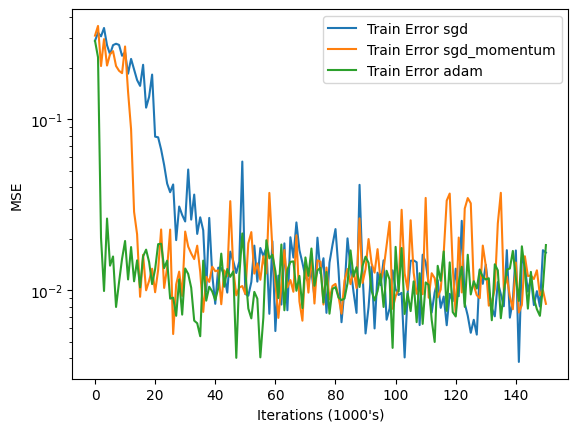

----------------------------------------
Width 20 Optimizer sgd
sgd Iteration 10000  Train Loss: 0.126
sgd Iteration 20000  Train Loss: 0.076
sgd Iteration 30000  Train Loss: 0.060
sgd Iteration 40000  Train Loss: 0.067
sgd Iteration 50000  Train Loss: 0.052
sgd Iteration 60000  Train Loss: 0.073
sgd Iteration 70000  Train Loss: 0.061
sgd Iteration 80000  Train Loss: 0.049
sgd Iteration 90000  Train Loss: 0.082
sgd Iteration 100000  Train Loss: 0.036
sgd Iteration 110000  Train Loss: 0.066
sgd Iteration 120000  Train Loss: 0.056
sgd Iteration 130000  Train Loss: 0.087
sgd Iteration 140000  Train Loss: 0.061
sgd Iteration 150000  Train Loss: 0.065
Width 20 Optimizer sgd
----------------------------------------
Width 20 Optimizer sgd_momentum
sgd_momentum Iteration 10000  Train Loss: 0.007
sgd_momentum Iteration 20000  Train Loss: 0.005
sgd_momentum Iteration 30000  Train Loss: 0.007
sgd_momentum Iteration 40000  Train Loss: 0.003
sgd_momentum Iteration 50000  Train Loss: 0.002
sgd_momen

----------------------------------------
Width 40 Optimizer sgd
sgd Iteration 10000  Train Loss: 0.085
sgd Iteration 20000  Train Loss: 0.060
sgd Iteration 30000  Train Loss: 0.022
sgd Iteration 40000  Train Loss: 0.008
sgd Iteration 50000  Train Loss: 0.006
sgd Iteration 60000  Train Loss: 0.007
sgd Iteration 70000  Train Loss: 0.006
sgd Iteration 80000  Train Loss: 0.007
sgd Iteration 90000  Train Loss: 0.004
sgd Iteration 100000  Train Loss: 0.006
sgd Iteration 110000  Train Loss: 0.010
sgd Iteration 120000  Train Loss: 0.005
sgd Iteration 130000  Train Loss: 0.003
sgd Iteration 140000  Train Loss: 0.005
sgd Iteration 150000  Train Loss: 0.002
Width 40 Optimizer sgd
----------------------------------------
Width 40 Optimizer sgd_momentum
sgd_momentum Iteration 10000  Train Loss: 0.004
sgd_momentum Iteration 20000  Train Loss: 0.001
sgd_momentum Iteration 30000  Train Loss: 0.001
sgd_momentum Iteration 40000  Train Loss: 0.001
sgd_momentum Iteration 50000  Train Loss: 0.001
sgd_momen

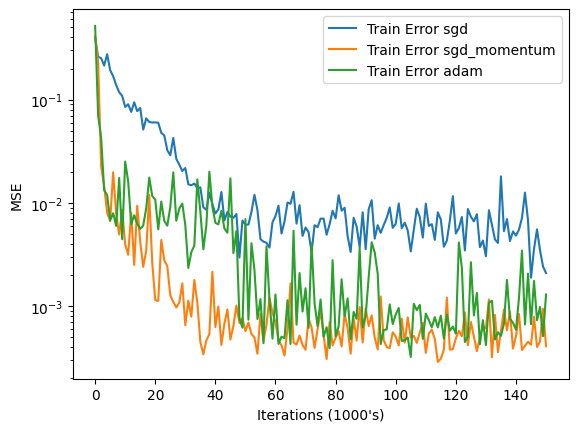

----------------------------------------
Trained all layers in 10.7 minutes


In [4]:
n_steps = 150000
save_every = 1000
t0 = time.time()
for w in widths:
    plt.figure()
    for optim in nets_by_size[w]:
      print("-"*40)
      print("Width", w, "Optimizer", optim)
      net = nets_by_size[w][optim]['net']
      opt_all = nets_by_size[w][optim]['opt_all']
      initial_weights = nets_by_size[w][optim]['init']
      history_all = train_network(X, y, X_test, y_test, 
                              net, optim=opt_all, 
                              n_steps=n_steps, save_every=save_every, 
                              initial_weights=initial_weights,
                              verbose=False, optimizer=optim)
      nets_by_size[w][optim]['hist_all'] = history_all
      print("Width", w, "Optimizer", optim)
      plot_test_train_errors(history_all, plot_train=True, optim=optim)
    plt.show()
t1 = time.time()
print("-"*40)
print("Trained all layers in %.1f minutes" % ((t1 - t0) / 60))

----------------------------------------
Width 10 Optimizer sgd
----------------------------------------
Width 10 Optimizer sgd_momentum
----------------------------------------
Width 10 Optimizer adam


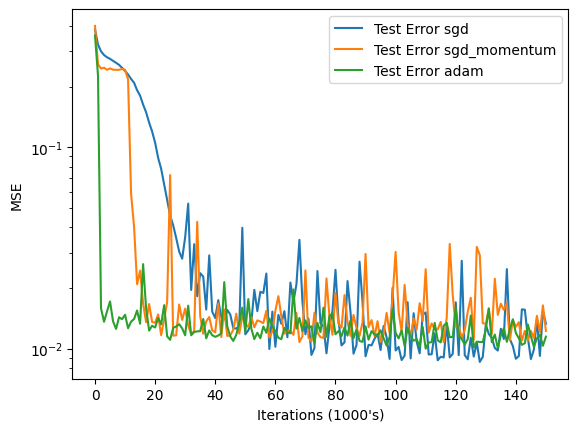

----------------------------------------
Width 20 Optimizer sgd
----------------------------------------
Width 20 Optimizer sgd_momentum
----------------------------------------
Width 20 Optimizer adam


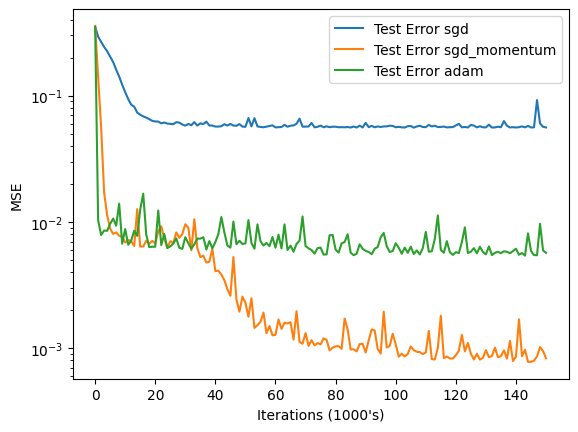

----------------------------------------
Width 40 Optimizer sgd
----------------------------------------
Width 40 Optimizer sgd_momentum
----------------------------------------
Width 40 Optimizer adam


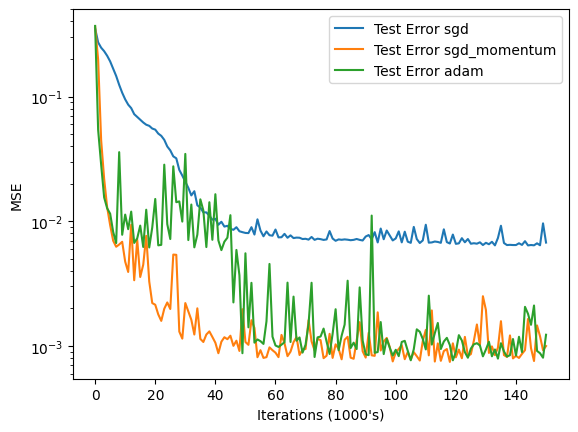

In [5]:
for w in widths:
    plt.figure()
    for optim in nets_by_size[w]:
        print("-"*40)
        print("Width", w, "Optimizer", optim)
        plot_test_train_errors(nets_by_size[w][optim]['hist_all'], plot_test=True, optim=optim)
    plt.show()
    

## Train All Layer Weights

Questions to consider while exploring the training process for all layer weights with different optimizers:
- **How does the hidden layer width and different optimizers impact the learned function and test error?**
- **What happens to the elbow locations using different optimizers during training?**
- **How do the final test error and learned function using different optimizers? Which one is more efficient? Your answer may differ for different hidden layer widths.**

Width 10


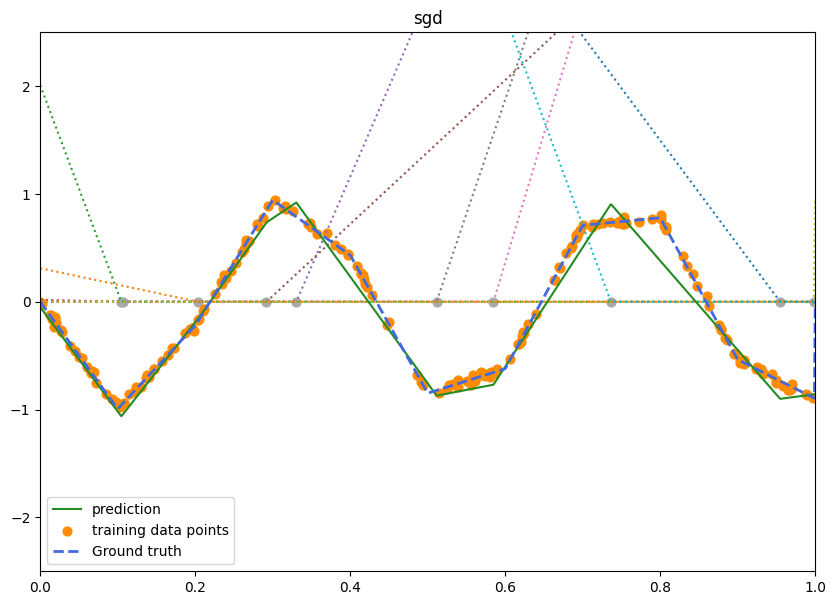

Width 10


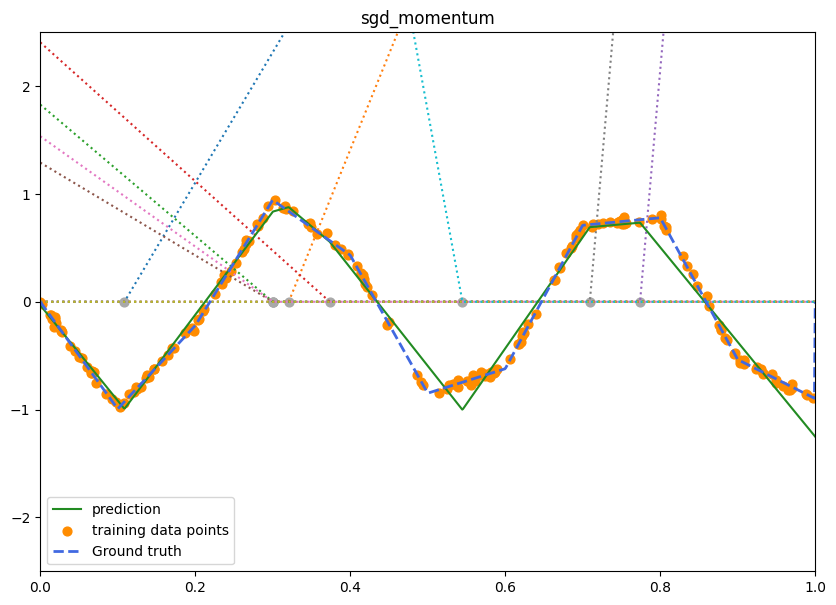

Width 10


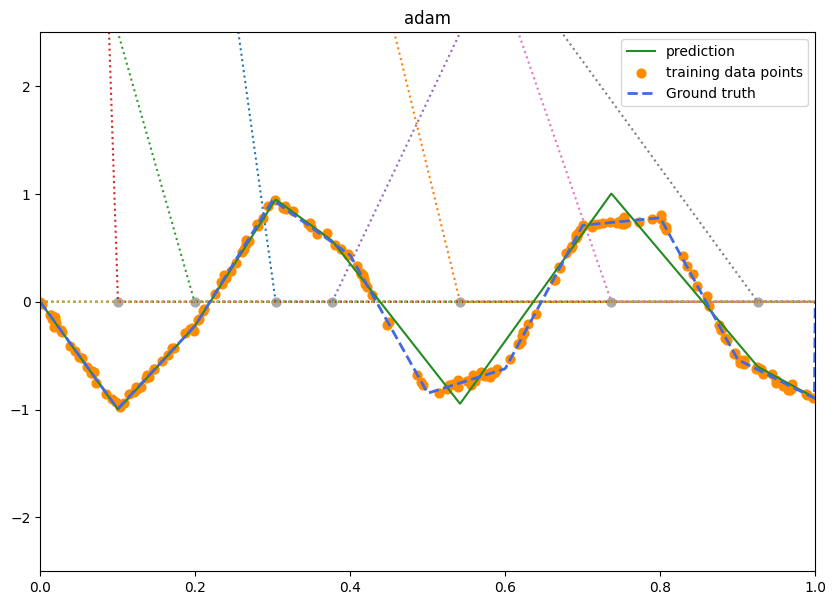

Width 20


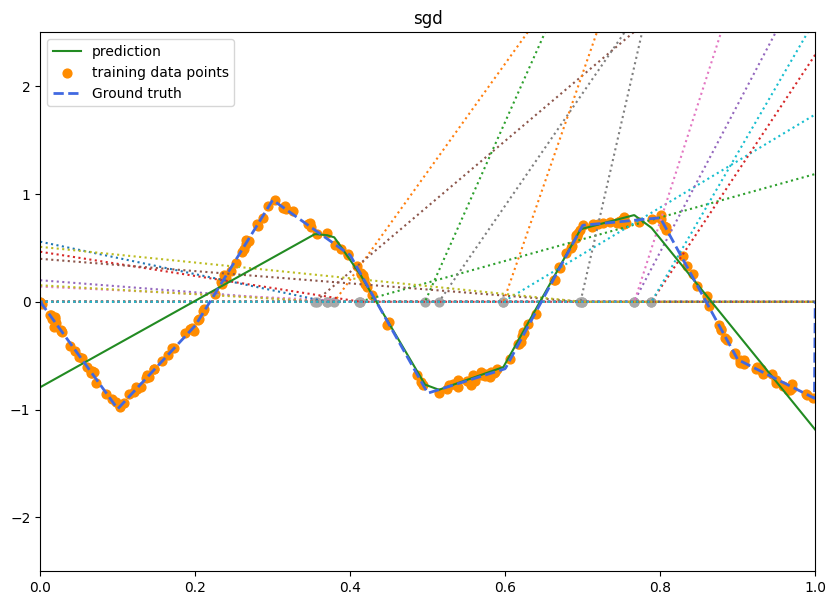

Width 20


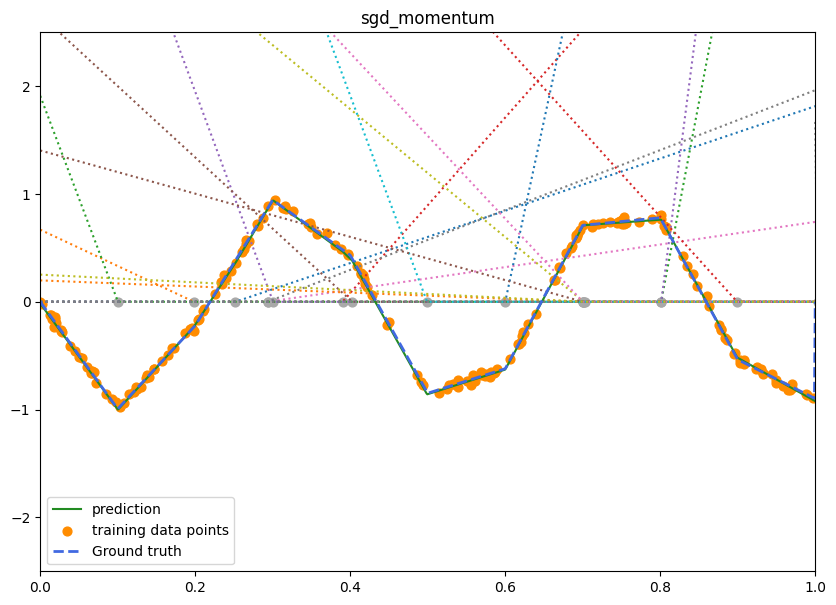

Width 20


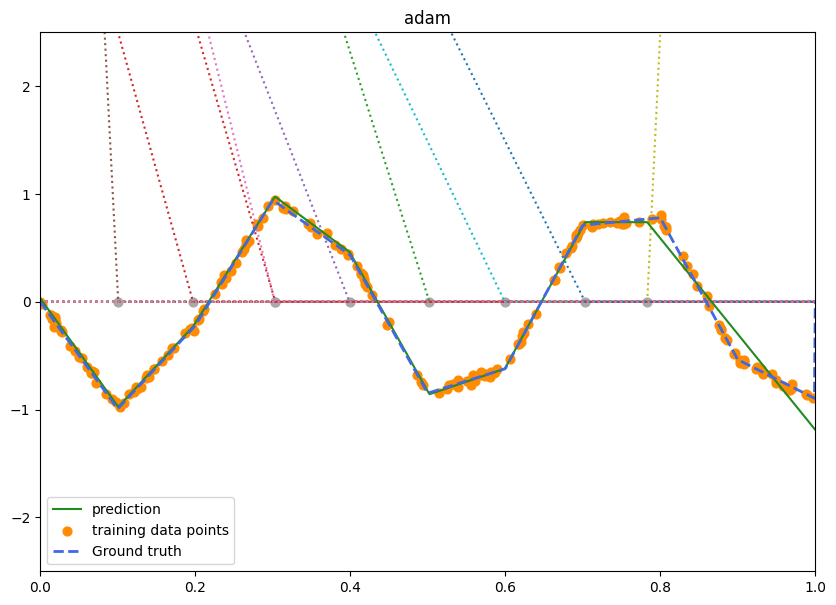

Width 40


Width 40


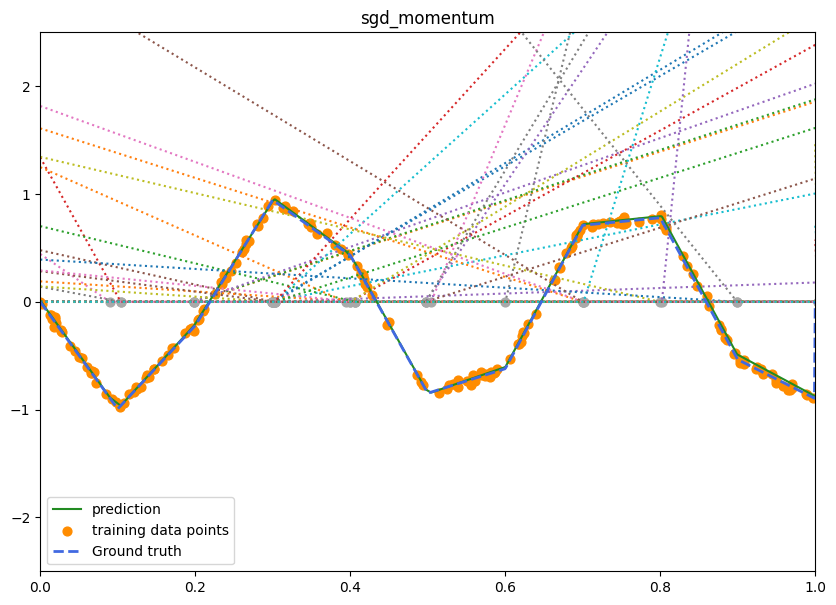

Width 40


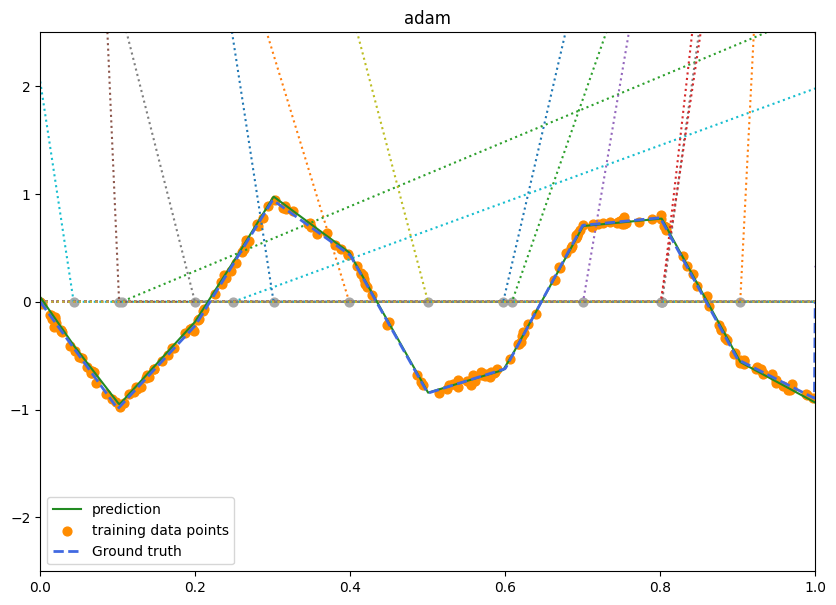

In [6]:
for w in widths:
    for optim in nets_by_size[w]:
        net = nets_by_size[w][optim]['net']
        print("Width", w)
        plot_update(X, y, X_test, y_test, net, optim=optim)